Question: Can we predict the amount of calories burnt during a workout based on biological measures?

In [ ]:
# imports
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

### Dataset Creation and Initial Treatment

In [3]:
# loading
df = pd.read_csv('calories.csv') # source: https://www.kaggle.com/datasets/ruchikakumbhar/calories-burnt-prediction/data

In [4]:
df.head(10)

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0
5,15130815,female,36,151.0,50.0,23.0,96.0,40.7,123.0
6,19602372,female,33,158.0,56.0,22.0,95.0,40.5,112.0
7,11117088,male,41,175.0,85.0,25.0,100.0,40.7,143.0
8,12132339,male,60,186.0,94.0,21.0,97.0,40.4,134.0
9,17964668,female,26,146.0,51.0,16.0,90.0,40.2,72.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


In [6]:
# setting up and cleaning
df = df.set_index('User_ID')  # set the column 'User_ID' as the dataset index
df = df.drop_duplicates()  # remove duplicates
df = df.fillna(0)  # fill empty columns with 0

In [7]:
# changing gender to binary numbers, so we can do a better correlation
df['Gender'] = df['Gender'].map({'male' : 0, 'female': 1})

### EDA (Exploratory Data Analisys)

In [8]:
df.describe()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.503500,42.790786,174.465831,74.967931,15.531035,95.518901,40.025488,89.542836
std,0.500004,16.980401,14.258333,15.035593,8.319310,9.583542,0.779244,62.457750
min,0.000000,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,0.000000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.000000,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.000000,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


In [9]:
# correlation: -1 is inversely proportional and 1 is directly proportional
df.corr()
# this shows us that the top three correlated (apparently) variables are duration, heart_rate and body_temperature

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
Gender,1.000000,-0.003165,-0.710522,-0.783171,-0.003388,-0.011518,-0.007220,-0.022306
Age,-0.003165,1.000000,0.009512,0.090038,0.013202,0.010449,0.013136,0.154356
Height,-0.710522,0.009512,1.000000,0.958452,-0.004664,0.000500,0.001167,0.017499
Weight,-0.783171,0.090038,0.958452,1.000000,-0.001940,0.004271,0.004048,0.035426
Duration,-0.003388,0.013202,-0.004664,-0.001940,1.000000,0.852866,0.903164,0.955419
Heart_Rate,-0.011518,0.010449,0.000500,0.004271,0.852866,1.000000,0.771523,0.897880
Body_Temp,-0.007220,0.013136,0.001167,0.004048,0.903164,0.771523,1.000000,0.824552
Calories,-0.022306,0.154356,0.017499,0.035426,0.955419,0.897880,0.824552,1.000000


In [10]:
# undo the binary gender representation
df['Gender'] = df['Gender'].map({0 : 'male', 1: 'female'})

In [11]:
# average height and weight between men and women
gender_groupby = df.groupby('Gender').agg({'Height': 'mean', 'Weight': 'mean', 'Calories': 'mean'})
gender_groupby

,Height,Weight,Calories
Gender,,,
female,164.405985,63.275026,88.159428
male,184.667517,86.825702,90.945750


In [12]:
# measures of men and women who burnt most calories
men_data = df[df['Gender'] == 'male'].sort_values(by='Calories', ascending=False)[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']]
men_data.head(10)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,,,,,,,
13079051,75,199.0,103.0,28.0,123.0,40.5,314.0
17545969,69,193.0,90.0,29.0,121.0,41.1,300.0
17825244,65,189.0,98.0,27.0,125.0,40.9,295.0
10784322,75,178.0,76.0,29.0,120.0,40.8,295.0
12114332,32,188.0,91.0,30.0,128.0,40.9,289.0
19360607,72,191.0,97.0,29.0,116.0,41.0,287.0
11190875,49,205.0,101.0,30.0,119.0,40.8,280.0
12733320,77,199.0,106.0,28.0,113.0,41.0,276.0
12958377,57,208.0,113.0,29.0,116.0,41.0,276.0


In [13]:
women_data = df[df['Gender'] == 'female'].sort_values(by='Calories', ascending=False)[['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']]
women_data.head(10)

,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,,,,,,,
17576120,67,157.0,56.0,28.0,122.0,40.7,240.0
13755382,72,182.0,74.0,30.0,118.0,41.0,240.0
14064841,70,157.0,57.0,29.0,118.0,40.8,238.0
16535127,60,159.0,55.0,30.0,117.0,40.9,238.0
15318976,74,148.0,50.0,30.0,113.0,40.7,235.0
18729934,73,153.0,53.0,28.0,119.0,40.8,235.0
13879882,55,162.0,57.0,28.0,122.0,40.9,234.0
11988053,51,152.0,58.0,30.0,117.0,41.3,232.0
12626325,63,147.0,54.0,29.0,117.0,40.4,232.0


In [14]:
# checking the correlation between duration and heart rate, and duration and body temp
filter_data = df.sort_values(by=['Duration', 'Body_Temp', 'Heart_Rate'], ascending=[True, False, False])
filter_data.head()

,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
User_ID,,,,,,,,
11930519,female,41,172.0,67.0,1.0,77.0,38.5,3.0
13592932,female,44,179.0,78.0,1.0,87.0,38.3,4.0
10888188,male,61,183.0,86.0,1.0,81.0,38.3,4.0
17571006,male,49,202.0,106.0,1.0,77.0,38.3,3.0
16053929,male,60,181.0,89.0,1.0,88.0,38.2,5.0


In [15]:
# attempt of representation of all the signficant variables in one scatter plot
fig = px.scatter(
    df, 
    x='Duration',
    y='Calories',
    color='Gender',
    size='Heart_Rate',
    trendline='ols', # linear regression line
    hover_data=['Height', 'Weight', 'Heart_Rate', 'Body_Temp'],
    labels={'Gender': 'Gender', 'Heart_Rate': 'Heart Rate (bpm)'},
    color_discrete_sequence=['blue', 'red']  # used for categorical variables color
)

fig.update_layout(
    title='Calories Burnt During a Workout',
    xaxis_title='Workout Duration (minutes)',
    yaxis_title='Calories Burnt'
)

fig.update_layout(width=1000, height=700)

fig.show()

# Building a model

In [16]:
# verifying the statistic relationship between the variables

y = df['Calories']  # target variable
X = df[['Duration', 'Body_Temp', 'Heart_Rate', 'Age', 'Height', 'Weight']]  # feature variables (the key variables to predict the target variable)

# constant
X = sm.add_constant(X)

# model
model = sm.OLS(y, X).fit()

# results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               Calories   R-squared:                       0.967
Model:                            OLS   Adj. R-squared:                  0.967
Method:                 Least Squares   F-statistic:                 7.360e+04
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        19:27:14   Log-Likelihood:                -57675.
No. Observations:               14999   AIC:                         1.154e+05
Df Residuals:                   14992   BIC:                         1.154e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        463.4395     11.104     41.735      0.0

The results indicates that our models is good at predicting, don't suffer with auto-correlation but the multicollinearity between the feature variables is a problem. I've checked before that the cause of this multicollinearity is the correlation between duration and heart rate and body temperature. It seems like duration affects directly these two variables, which means that they're not good predictors for the calories burnt.

In [17]:
# creating a linear regression model with Sklearn

# variables
X = np.array(df['Duration'])  # the main feature variable
X = X.reshape(-1, 1) # the model expects a matrix

y = df['Calories']

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# model 
model = LinearRegression()
model.fit(X_train, y_train)

# score
score = model.score(X_test, y_test)
print(score)

# coefficients
print(model.coef_)
print(model.intercept_)

0.9115536717791662
[7.16424374]
-21.63570869148616


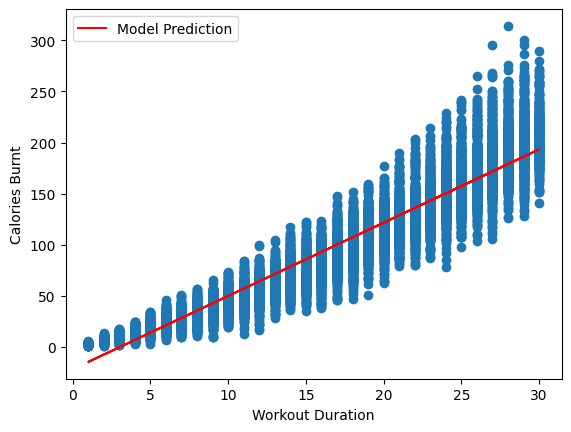

In [18]:
# plotting with matplotlib
plt.scatter(X, y)
plt.plot(X, model.predict(X), color="red", label='Model Prediction')
plt.xlabel('Workout Duration')
plt.ylabel('Calories Burnt')
plt.legend()
plt.show()

Deploy: the model is deployed on the deploy.py file, using a streamlit interface.